# Weather Trends Over The Decades

I am using data from NOAA to show weather data for the Lexington, Kentucky region over the years.  We are luck enough to have a massive amount of data available to us starting from the late 1940s. 

My thought process is this: it seems that every year the summers are hotter and hotter, the winters not as cold, and lots of extremes throughout the year.  With this data, will we see a trend upwards in the average temperatures? Is the max temperature steadily going up, or staying about the same?  How about the miniumum temperature? Is the percipitation changing as well? 

In [40]:
import pandas as pd
import numpy as np
import os
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns


In [41]:
# SETTING UP THE DB INFO
DB_PATH = os.path.join('data', 'weather.db')

conn = sqlite3.connect(DB_PATH)

In [3]:
# Fetching the data from the DB and joining the two tables based off the DATE column #
def fetch_data(conn: sqlite3.Connection) -> pd.DataFrame:
    """
    Returns a dataframe based off the weather_dailies and weather_main in the tables.
    We will be JOINing the two tables based off the DATE column.  
    I will average the TMAX, TMIN, and TAVG columns from the weather_dailies table, as there are more than one rows per day.
    """

    query =  """
    WITH d AS (
        SELECT 
            DATE,
            MAX(CAST(TMAX AS DECIMAL(10, 2))) AS TMAX,
            MIN(CAST(TMIN AS DECIMAL(10, 2))) AS TMIN,
            AVG(CAST(TAVG AS DECIMAL(10, 2))) AS TAVG
        FROM weather_dailies
        GROUP BY DATE
    )
    SELECT 
        m.DATE,
        m.SEASON,
        m.YEAR,
        m.DATA_SOURCE,
        m.STATION,
        m.NAME,
        m.TEMP,
        m.PRCP,
        m.DEWP,
        d.TMAX,
        d.TMIN,
        d.TAVG
    FROM weather_main m
    LEFT JOIN d
    ON m.DATE = d.DATE
    ORDER BY m.DATE;
    """
    
    return pd.read_sql_query(query, conn, parse_dates=["DATE"])

df_main = fetch_data(conn)

## Average Annual Temperature 

For the first plot, I figured a basic overview of the data to see what it shows would be the best place to start.  For this graph, I took the average temperature for the year, based off of the average temperature of each day, and plotted each point. 


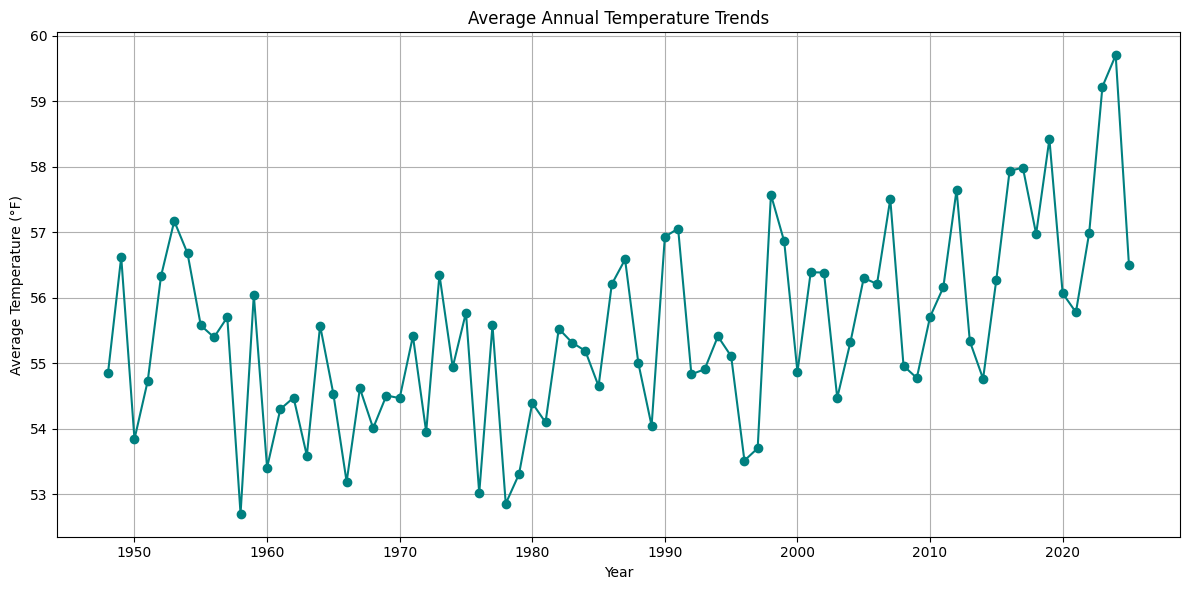

In [4]:
# Temperature TRENDS over the years #
# A very basic look at the temperature trends over the years #

yearly_data = df_main.groupby('YEAR')['TEMP'].mean().reset_index()

plt.figure(figsize=(12,6))
plt.plot(yearly_data['YEAR'], yearly_data['TEMP'], marker='o', linestyle='-', color='teal')
plt.title('Average Annual Temperature Trends')
plt.xlabel('Year') 
plt.ylabel('Average Temperature (°F)')
plt.grid(True)
plt.tight_layout() 
plt.show()

Something I noticed that was very interesting is that the yearly average is not above 60°F.  I was expecting this to be a bit higher, honestly.  Which led me to plot out and check out the max temperatures for the years.

## Average max average temperature trends

For this plot, we're looking at the max AVERAGE temperature since 2000.  Because there was only so much data available with daily highs and lows, I limited my range for these values to the 2000s.  This is nearly 25 years worth of data, and we are including data from 2025 - this information ends in July.  This will really skew the data for 2025, and I'm considering dropping this year for the following graphs.  For now, keep in mind that the data for this year is currently incomplete.

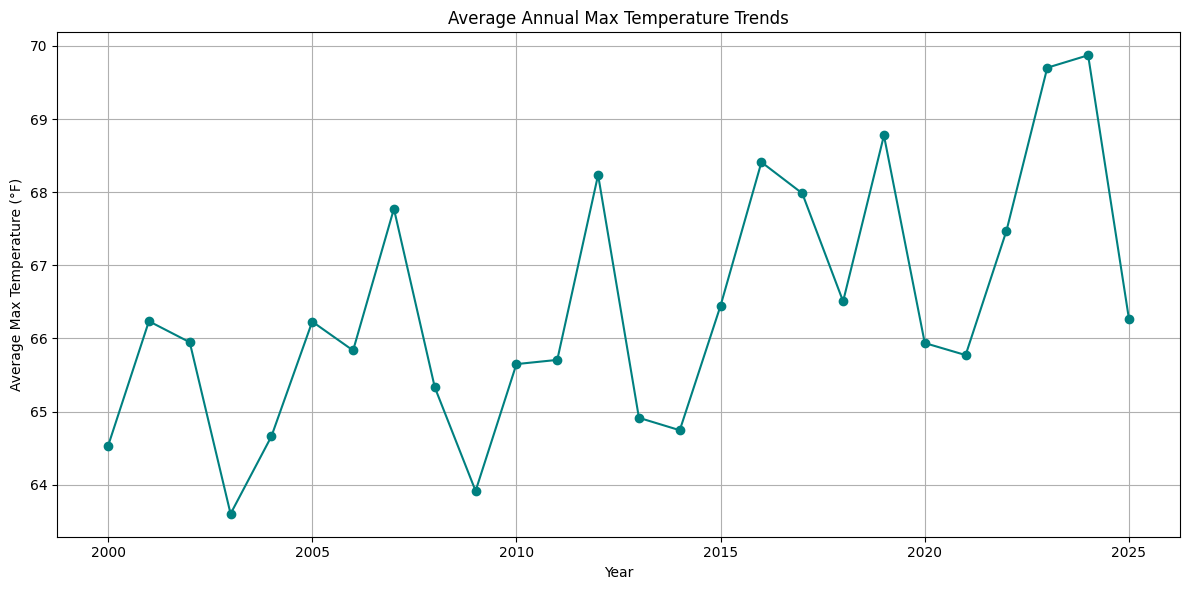

In [5]:
# Max temperature trends over the years #
# Seeing the average increase, but stay below 60 is interesting.. 

yearly_data = df_main.groupby('YEAR')['TMAX'].mean().reset_index()

plt.figure(figsize=(12,6))
plt.plot(yearly_data['YEAR'], yearly_data['TMAX'], marker='o', linestyle='-', color='teal')
plt.title('Average Annual Max Temperature Trends')
plt.xlabel('Year') 
plt.ylabel('Average Max Temperature (°F)')
plt.grid(True)
plt.tight_layout() 
plt.show()

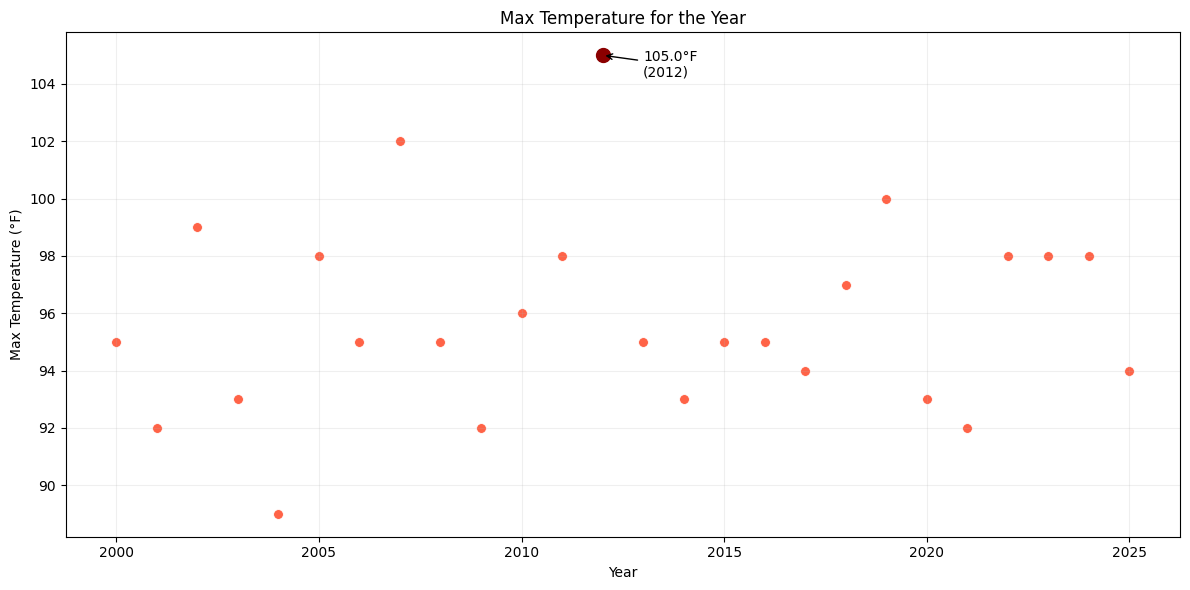

In [78]:
# What is the MAX temp for the year?

max_temp_by_year = df_main.groupby('YEAR')['TMAX'].max().reset_index()
max_tmax_value = max_temp_by_year['TMAX'].max()
max_tmax_year = max_temp_by_year.loc[max_temp_by_year['TMAX'].idxmax(), 'YEAR']

plt.figure(figsize=(12, 6))
sns.scatterplot(data=max_temp_by_year, x='YEAR', y='TMAX', marker='o', s=50, color='tomato')
plt.scatter(max_tmax_year, max_tmax_value, color='darkred', s=100, label=f'Max: {max_tmax_value:.2f}°F')
plt.annotate(f'{max_tmax_value}°F\n({int(max_tmax_year)})',
             xy=(max_tmax_year, max_tmax_value),
             xytext=(max_tmax_year + 1, max_tmax_value - .75),
             arrowprops=dict(facecolor='steelblue', arrowstyle='->'),
             fontsize=10)

plt.title("Max Temperature for the Year")
plt.xlabel('Year')
plt.ylabel('Max Temperature (°F)')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

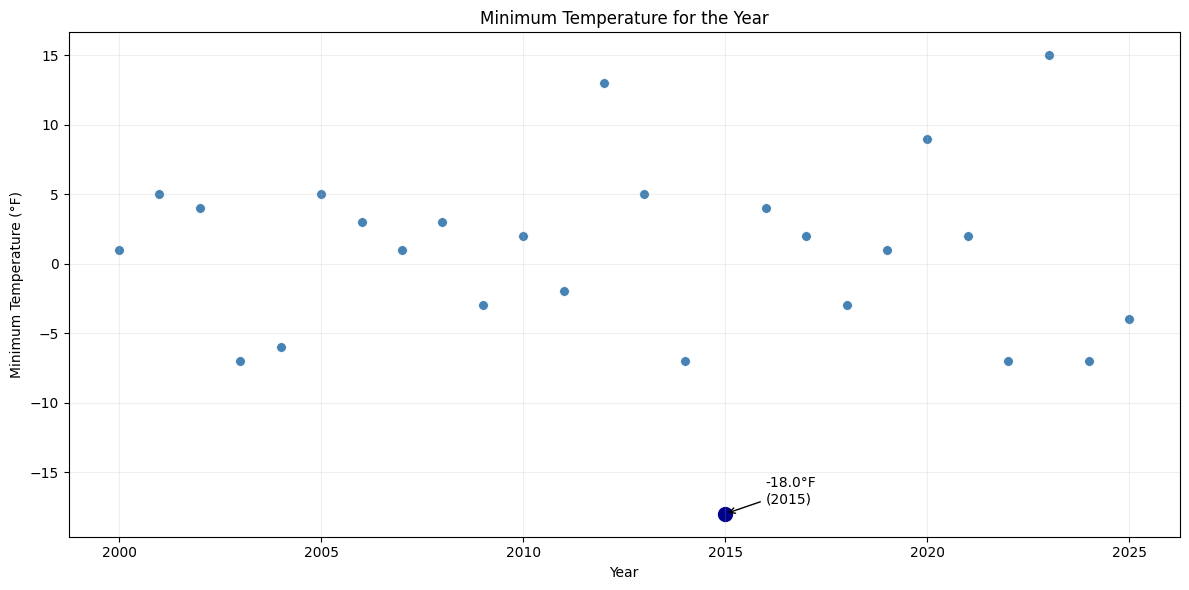

In [83]:
# Now we might as well look at what the MIN temp was for each year

min_temp_by_year = df_main.groupby('YEAR')['TMIN'].min().reset_index()
min_tmin_value = min_temp_by_year['TMIN'].min()
min_tmin_year = min_temp_by_year.loc[min_temp_by_year['TMIN'].idxmin(), 'YEAR']

plt.figure(figsize=(12, 6))
sns.scatterplot(data=min_temp_by_year, x='YEAR', y='TMIN', marker='o', s=50, color='steelblue')
plt.scatter(min_tmin_year, min_tmin_value, color='darkblue', s=100, label=f'Min: {min_tmin_value:.2f}°F')
plt.annotate(f'{min_tmin_value}°F\n({int(min_tmin_year)})',
             xy=(min_tmin_year, min_tmin_value),
             xytext=(min_tmin_year + 1, min_tmin_value + .75),
             arrowprops=dict(facecolor='darkblue', arrowstyle='->'),
             fontsize=10)
plt.title('Minimum Temperature for the Year')
plt.xlabel('Year')
plt.ylabel('Minimum Temperature (°F)')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

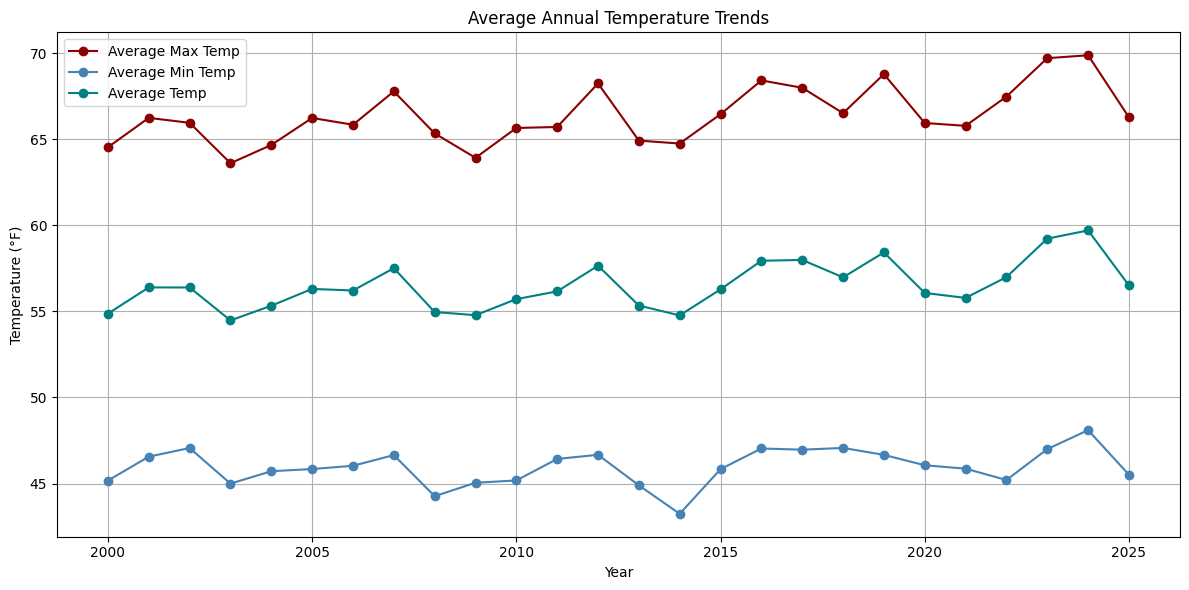

In [7]:
current_data = df_main[df_main['DATA_SOURCE'] == 'current']

yearly_current = current_data.groupby('YEAR').agg({
    'TMAX': 'mean',
    'TMIN': 'mean',
    'TEMP': 'mean'  # optional if you want to include it
}).reset_index()

plt.figure(figsize=(12, 6))
plt.plot(yearly_current['YEAR'], yearly_current['TMAX'], label='Average Max Temp', color='darkred', marker='o')
plt.plot(yearly_current['YEAR'], yearly_current['TMIN'], label='Average Min Temp', color='steelblue', marker='o')
plt.plot(yearly_current['YEAR'], yearly_current['TEMP'], label='Average Temp', color='teal', marker='o')
plt.title('Average Annual Temperature Trends')
plt.xlabel('Year')
plt.ylabel('Temperature (°F)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



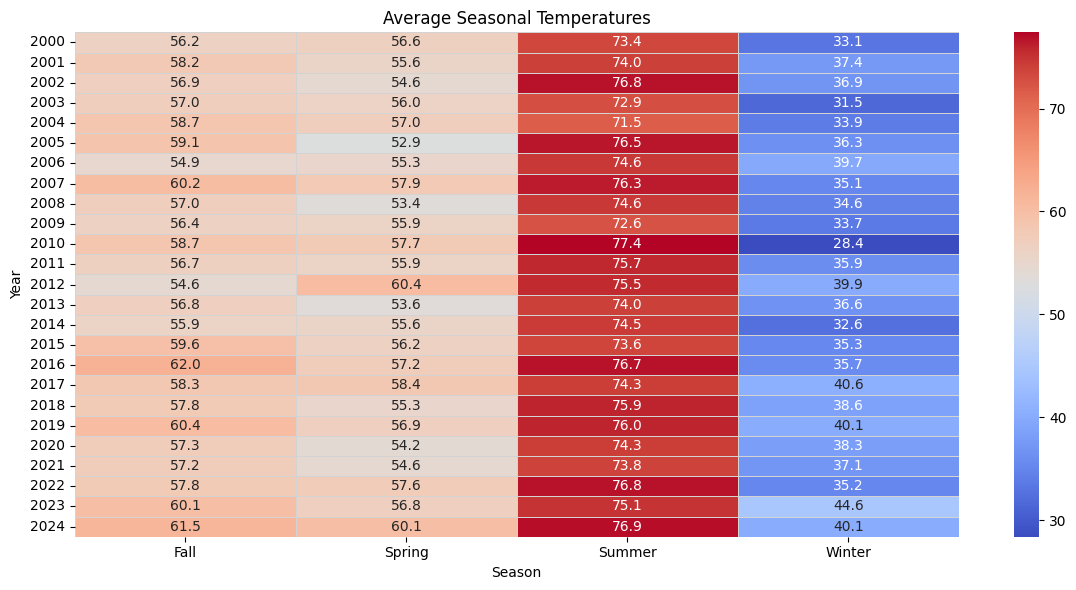

In [73]:
df_seasonal = df_main[df_main['DATA_SOURCE'] == 'current']

seasonal_avg = df_seasonal.groupby(['YEAR', 'SEASON']).agg({
    'TMAX': 'mean',
    'TMIN': 'mean',
    'TEMP': 'mean'
}).round(1).reset_index()

# Removing 2025 from the data as it is not complete
seasonal_avg = seasonal_avg[seasonal_avg['YEAR'] != 2025]

heatmap_data = seasonal_avg.pivot(index='YEAR', columns='SEASON', values='TEMP')

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap='coolwarm', linewidths=0.5, linecolor='lightgrey')
plt.title('Average Seasonal Temperatures')
plt.xlabel('Season')
plt.ylabel('Year')
plt.tight_layout()
plt.show()


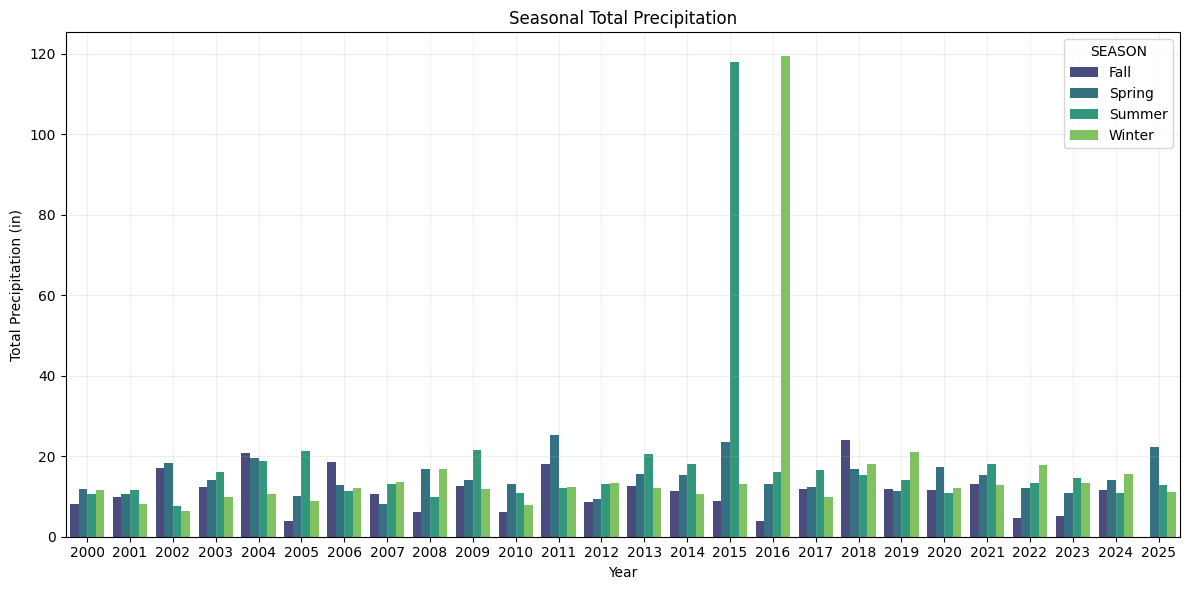

In [75]:
prcp_seasonal = df_seasonal.groupby(['YEAR', 'SEASON']).agg({
    'PRCP': 'sum'
}).round(2).reset_index()

prcp_seasonal.head(15)

plt.figure(figsize=(12, 6))
sns.barplot(data=prcp_seasonal, x='YEAR', y='PRCP', hue='SEASON', palette='viridis')
plt.title('Seasonal Total Precipitation')
plt.xlabel('Year')
plt.ylabel('Total Precipitation (in)')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()